# A Prediction of Ames House Price
---
### Research task for Data Analysis course at SSE masters program
### HSE, spring of 2020

**Authors:** [Miron Rogovets](https://github.com/Mist3r-R), [Demid Afonichev](https://github.com/demidafonichev)

---

![house](images/housesbanner.png)

The dataset was taken from **"House Prices: Advanced Regression Techniques"** [competition on Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

With *SalePrice* target variable and *79 explanatory variables* it describes (almost) every aspect of residential homes in Ames, Iowa.

Full data description, as well as competition description and more details, can be found via link above.

---

## Table of contents

1. [Data exploration](#data-expl)
    - [Target variable analysis](#target-an)
    - [Outliers](#outliers)
    - [Missing data](#missing)  
 
 
2. [Data preprocessing](#data-prep)
     - [Filling missing data](#fill-missing)
     - [Outliers removing](#rem-outliers)
     - [SalePrice normalization](#num-tar)
     - [Numeric features fixing](#num-fix)
     

3. [Model fitting](#model-fit)
    - [Simple OLS model](#ols)
    - [Model diagnostics](#ols-diag)
    - [Multicollinearity elimination](#multi-elim)

---

First, we start with imports and data output configuration

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import kstest
from scipy.stats import zscore, norm

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.outliers_influence import OLSInfluence as influence

import warnings

In [12]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
#Limit floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

Now we can load our data. The dataset is already split into train and test parts.

In [13]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('train : ' + str(train.shape))
print('test : ' + str(test.shape))

train : (1460, 81)
test : (1459, 80)


In [14]:
# Preview train data
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [15]:
# Preview test data
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


## 1. Data exploration <a name="data-expl"></a>

Full list of variables in our dataset:

In [16]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Let's examine types of our variables:

In [17]:
for t in train.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, train.dtypes[train.dtypes==t].index.values))

Type: int64
['Id' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold' 'SalePrice']

Type: object
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType

In [18]:
print(len(train.dtypes[train.dtypes=='object'].index.values))
print(len(train.dtypes[train.dtypes!='object'].index.values))

43
38


We should pay attention to the fact that not every numeric feature is really numeric according to <code>data_description.txt</code> and keep it in mind when we proceed to features engineering.

We can also drop __ID__ variable, since we're not interested in it:

In [19]:
train.drop(columns=['Id'], inplace=True)
test_ids = test.Id
test.drop(columns=['Id'], inplace=True)
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [20]:
print('train : ' + str(train.shape))
print('test : ' + str(test.shape))

train : (1460, 80)
test : (1459, 79)


### Target variable analysis <a name="target-an"></a>

**'SalePrice'** is the variable we're trying to predict, so we start our analysis with it's exploration.

In [21]:
train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

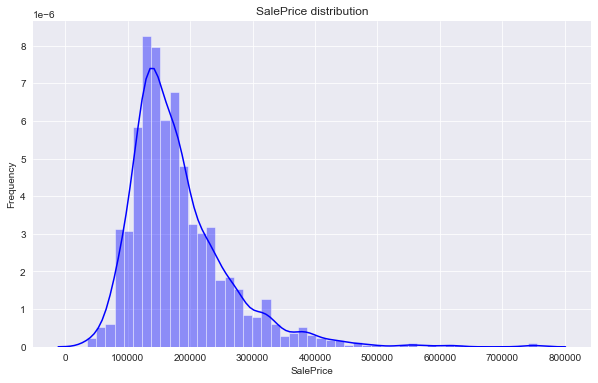

In [22]:
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(train['SalePrice'], color='b');
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

We can have a look at the **Normal probability plot**: data distribution should closely follow the diagonal that represents the normal distribution.

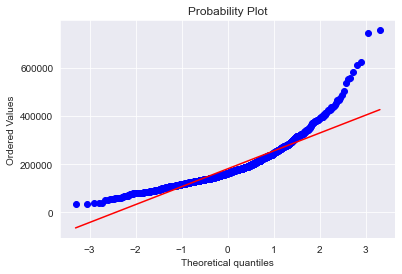

In [23]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [24]:
print('Skewness: {:.4f}'.format(train['SalePrice'].skew()))
print('Kurtosis: {:.4f}'.format(train['SalePrice'].kurt()))

Skewness: 1.8829
Kurtosis: 6.5363


We can see that the target variable:
* deviates from normal distribution
* is positevly skewed and leptokurtic
* does not follow the diagonal line

#### Target variable's relationship with other variables

We start with correlation matrix (heatmap style):

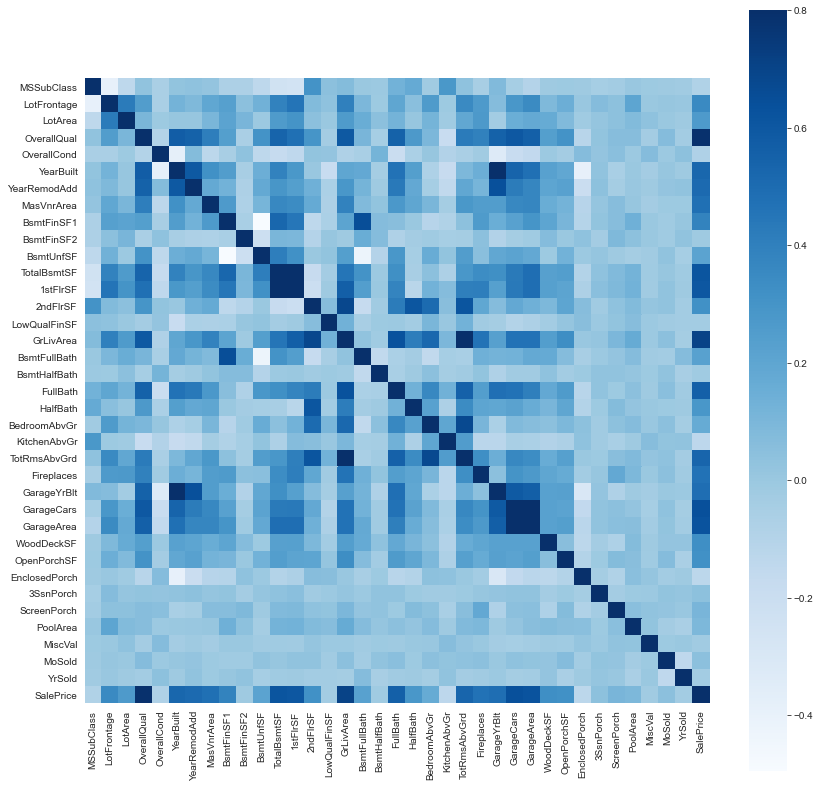

In [25]:
corr = train.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, vmax=.8, square=True, cmap='Blues')
plt.show()

We can see that there are two dark squares with very high correlation. The first one consists of __'TotalBsmtSF'__ and __'1stFlrSF'__ variables, and the second one consists of __'Garage'__ variables.

We should also pay attention to __'SalePrice'__ correlations. __'OverallQual'__  and __'GrLivArea'__ have the highest correlation, but we can also notice many other variables that should be taken into account.

Then we build correlation matrix for 'SalePrice':

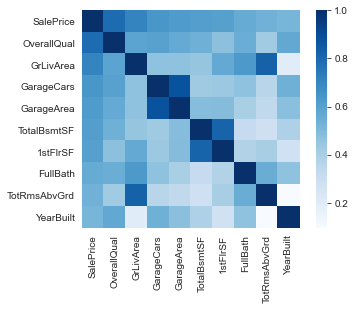

In [26]:
cols = corr.nlargest(10, 'SalePrice').index
sns.heatmap(np.corrcoef(train[cols].values.T), square=True, 
            yticklabels=cols.values, xticklabels=cols.values, cmap='Blues')
plt.show()

We can see the following from the heatmap above:
- 'OverallQual'and GrLivArea' have the highest correlation with 'SalePrice'
- 'GarageCars' and 'GarageArea' also have strong correlation with target variable. At the same time their correlation with each other is very strong too, which can be explained as the larger area of the garage can fit more cars. We should keep only one of them ('GarageCars', as it has higher correlation) when we proceed to price prediction
- The situation is the same with 'TotalBsmtSF' and '1stFlrSF'. This can be explained by an assumption that mostly the area of basement does not exceed the area of 1st floor
- The same is with 'TotRmsAbvGrd' and 'GrLivArea' (the total area fully depends on area of all rooms)

Then, we should check the scatterplots:

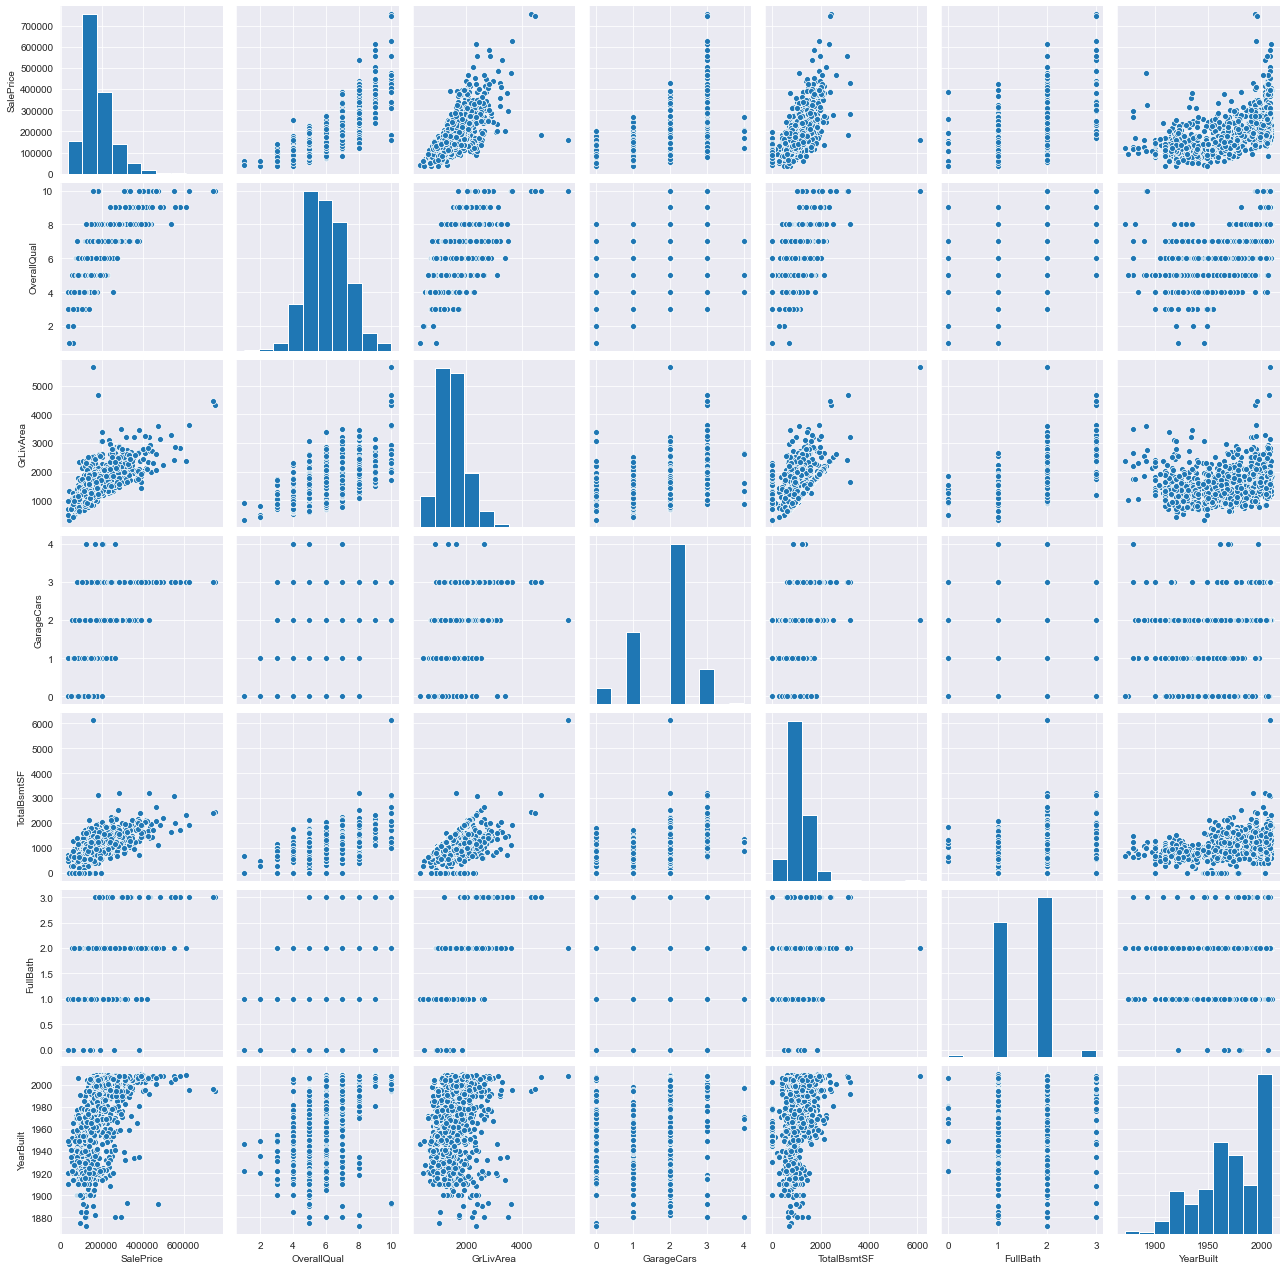

In [27]:
sns.pairplot(train[cols.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'])], size=2.5)
plt.show()

We can see some outliers present in our dataset and some interesting patterns in variables relationship.

### Outliers <a name="outliers"></a>

Let's have a closer look at 'GrLivArea' and 'TotalBsmtSF':

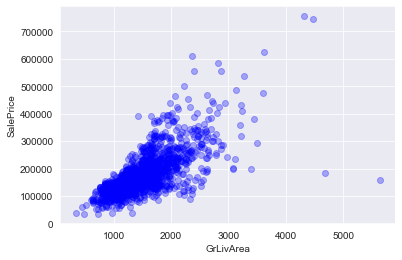

In [28]:
plt.scatter(train.GrLivArea, train.SalePrice, c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

We can see 2 extreme outliers on the bottom right: really large houses were sold for really cheap.

Moreover, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset. Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

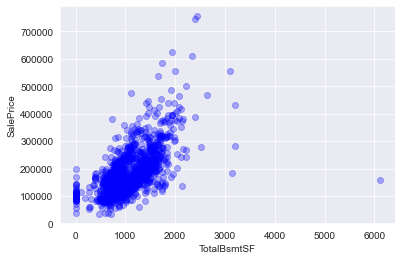

In [29]:
plt.scatter(train.TotalBsmtSF, train.SalePrice, c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')
plt.show()

We can see a positive linear relationship in both cases.

And let's have a look at 'OverallQual' and 'YearBuilt':

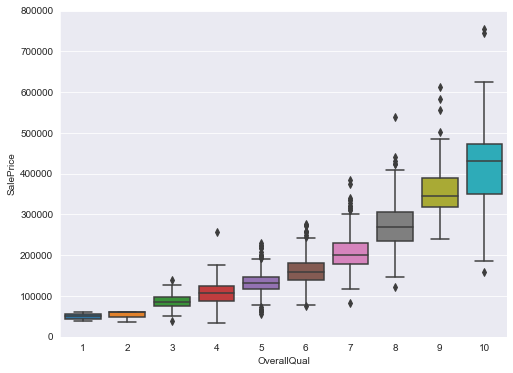

In [30]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y='SalePrice', 
                  data=pd.concat([train['SalePrice'], train['OverallQual']], axis=1))
fig.axis(ymin=0, ymax=800000)
plt.show()

Everything seems to be OK (the higher the quality, the higher the price)

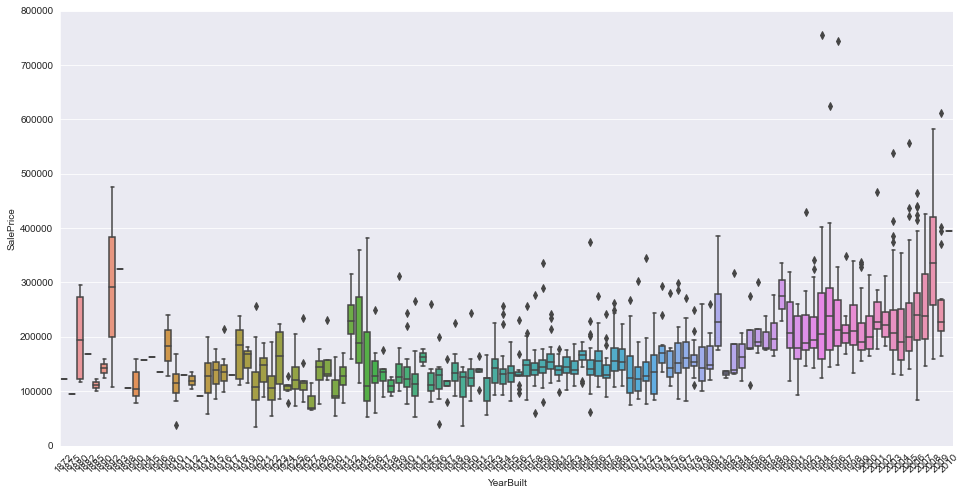

In [31]:
plt.figure(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", 
                  data=pd.concat([train['SalePrice'], train['YearBuilt']], axis=1))
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=45)
plt.show()

Looks like the price for the new houses is likely to be higher than for the old ones.

### Missing data <a name="missing"></a>

In [32]:
missing = (train.isna().sum() / len(train)) * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing = pd.DataFrame({'Ratio' : missing})
missing

,Ratio
PoolQC,99.521
MiscFeature,96.301
Alley,93.767
Fence,80.753
FireplaceQu,47.260
LotFrontage,17.740
GarageYrBlt,5.548
GarageType,5.548
GarageFinish,5.548
GarageQual,5.548


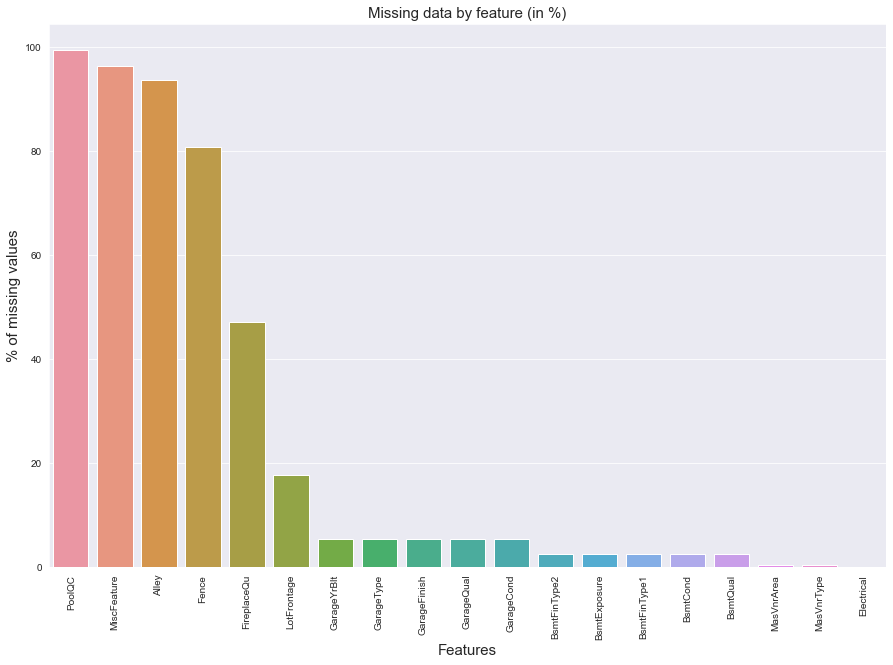

In [33]:
plt.figure(figsize=(15, 10))
sns.barplot(x=missing.index, y=missing.Ratio)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('% of missing values', fontsize=15)
plt.title('Missing data by feature (in %)', fontsize=15)
plt.show()

In [34]:
missing_test = (test.isna().sum() / len(test)) * 100
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
missing_test = pd.DataFrame({'Ratio' : missing_test})
missing_test

,Ratio
PoolQC,99.794
MiscFeature,96.504
Alley,92.666
Fence,80.123
FireplaceQu,50.034
LotFrontage,15.559
GarageYrBlt,5.346
GarageCond,5.346
GarageQual,5.346
GarageFinish,5.346


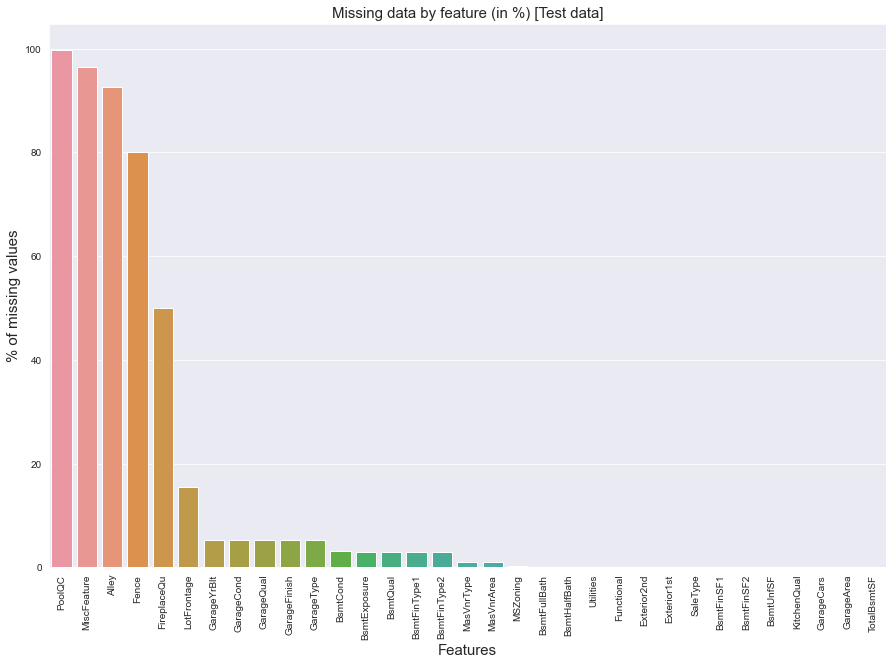

In [35]:
plt.figure(figsize=(15, 10))
sns.barplot(x=missing_test.index, y=missing_test.Ratio)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('% of missing values', fontsize=15)
plt.title('Missing data by feature (in %) [Test data]', fontsize=15)
plt.show()

Looks like most part of the data is missing for 'PoolQC', 'MiscFeature', 'Alley' and 'Fence'. But since these vairables represent the quality or type of particular feature, _NaN_ value represents the absense of them.

The same is true about other categorical features. 

We can also note that there are several variables that have missing values only in test data.

In [36]:
only_train = [i for i in missing.index if i not in missing_test.index]
only_test = [i for i in missing_test.index if i not in missing.index]
print('Only in train data:\n{}\n'.format(only_train))
print('Only in test data:\n{}'.format(only_test))

Only in train data:
['Electrical']

Only in test data:
['MSZoning', 'BsmtFullBath', 'BsmtHalfBath', 'Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 'SaleType', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'KitchenQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF']


We should also check if we have any categorical variables with the same values for the whole dataset:

In [37]:
for c in test.dtypes[train.dtypes=='object'].index.values:
    if len(test[c].dropna().unique()) == 1:
        print(c)

Utilities


In [38]:
print(train.Utilities.value_counts())
print(test.Utilities.value_counts())

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
AllPub    1457
Name: Utilities, dtype: int64


We do not really need this variable, since it won't tell us anything in prediction.

---

## 2. Data preprocessing <a name="data-prep"></a>

After exploring the data we should preprocess it. We start with filling missing values and recoding some numerical variables that are really categorical. Then we deal with outliers and normalization of target variable. Finally, we fix categorical and numeric features.

First, we drop **Utilities** variable:

In [39]:
train.drop(columns=['Utilities'], inplace=True)
test.drop(columns=['Utilities'], inplace=True)

### Filling missing data <a name="fill-missing"></a>

The strategy is the following:

- **PoolQC:** data description says NaN means "no pool"
- **Fence:** data description says NaN means "no fence"
- **MiscFeature:** data description says NaN means "no misc feature"
- **Alley:** data description says NaN means "no alley access"
- **FireplaceQu:** data description says NaN means "no fireplace"
- **GarageType, GarageFinish, GarageQual & GarageCond:** data description says NaN means "no garage"
- **GarageYrBlt, GarageArea & GarageCars:** replacing missing data with 0 (no garage == no cars)
- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 & BsmtFinType2:** data description says NaN means "no basement"
- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath & BsmtHalfBath:** NaN values are likely zero (since no basement)
- **LotFrontage:** since the areas of each street connected to the house property most likely have a similar area to other houses in its neighborhood, we can fill in missing values by the median **LotFrontage** of the neighborhood
- **MasVnrArea & MasVnrType:** NaN most likely means no masonry veneer
- **Functional:** data description says NaN means typical ('Typ')
- **MSSubClass:** NaN most likely means No building class
- **MSZoning, Electrical, KitchenQual, Exterior1st, Exterior2nd & SaleType:** all of them have too little number of missing values and can be replaced with most common values

Then, we should convert some non-numeric variables that are stored in numbers into strings

In [40]:
def convert(data):
    data['MSSubClass'] = data['MSSubClass'].apply(str)
    data['YrSold'] = data['YrSold'].astype(str)
    data['MoSold'] = data['MoSold'].astype(str)
    #data['GarageYrBlt'] = data['GarageYrBlt'].astype(str)
    #data['YearBuilt'] = data['YearBuilt'].astype(str)
    #data['YearRemodAdd'] = data['YearRemodAdd'].astype(str)
    return data

In [41]:
train = convert(train)
test = convert(test)

In [42]:
def fill_missing(data):
    for c in ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu']:
        data[c] = data[c].fillna('None')
    
    for c in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        data[c] = data[c].fillna('None')
    
    for c in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        data[c] = data[c].fillna(0)
    
    for c in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        data[c] = data[c].fillna('None')
    
    for c in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
        data[c] = data[c].fillna(0)
    
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['MSSubClass'] = data['MSSubClass'].fillna('None')
    data['Functional'] = data['Functional'].fillna('Typ')
    
    for c in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
        data[c] = data[c].mode()[0]
    
    return data
    

In [43]:
train = fill_missing(train)
test = fill_missing(test)

Let's check if we filled all missing values:

In [44]:
print('Train: {}'.format(train.isna().sum().sum()))
print('Test: {}'.format(test.isna().sum().sum()))

Train: 0
Test: 0


All data seems to be cleaned, now we can proceed to dealing with outliers.

### Outliers removing <a name="rem-outliers"></a>

From the **Data exploration** section we remember that 'GrLivArea' has outliers that should be removed. Now, let's get rid of them:

In [45]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

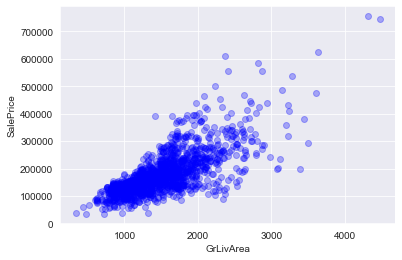

In [46]:
plt.scatter(train.GrLivArea, train.SalePrice, c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

### SalePrice normalization <a name="num-tar"></a>

As we remember, our target variable deviates from normal distribution, so we should fix it.

This can be achieved with log-transformation ( $log(1+x)$ ):

In [47]:
train['SalePrice'] = np.log1p(train['SalePrice'])

Now let's check the distribution of target variable:

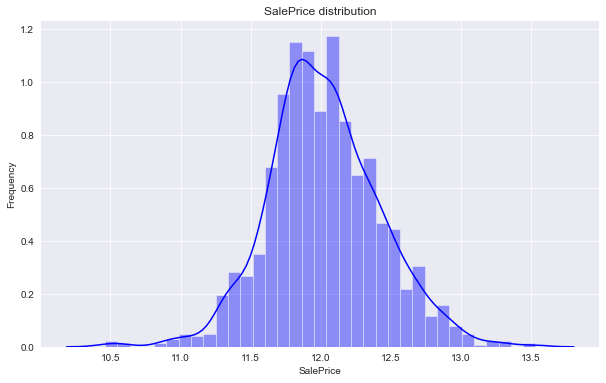

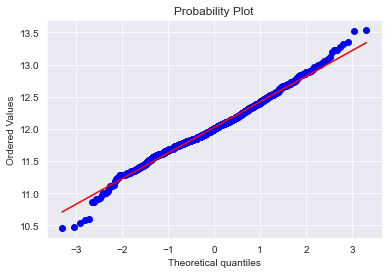

In [48]:
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(train['SalePrice'], color='b');
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The variable appears to be normally distributed.

Now we can proceed to fixing numeric features.

### Numeric features fixing <a name="num-fix"></a>

First, we get rid of strongly correlated features to avoid multicollinearity:

In [49]:
train.drop(columns=['GarageArea', 'GarageYrBlt'], inplace=True)
test.drop(columns=['GarageArea', 'GarageYrBlt'], inplace=True)

Then we check the distributions of numeric features:

In [50]:
numeric = train.dtypes[train.dtypes != 'object'].index.values
numeric

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'SalePrice'], dtype=object)

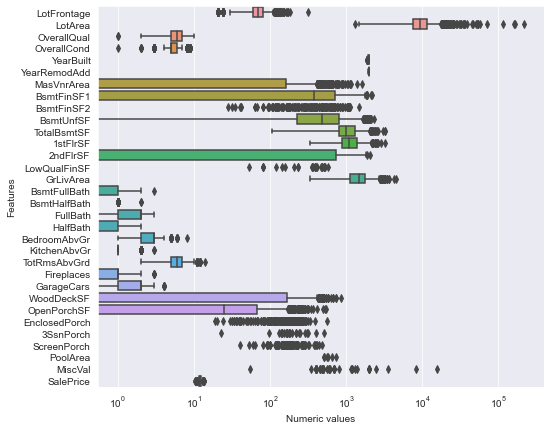

In [51]:
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data=train[numeric] , orient='h')
ax.set(ylabel='Features')
ax.set(xlabel='Numeric values')
plt.show()

In [52]:
def get_skewed(data, cols):
    skewed = data[cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    skewed = skewed[np.abs(skewed) > 0.75]
    print('There are {} numerical features with Skew > 0.75'.format(skewed.shape[0]))
    skewness = pd.DataFrame({'Skew': skewed})
    return skewness

In [53]:
skewed = get_skewed(train, numeric)
skewed

There are 19 numerical features with Skew > 0.75


,Skew
MiscVal,24.460
PoolArea,15.949
LotArea,12.574
3SsnPorch,10.297
LowQualFinSF,9.005
KitchenAbvGr,4.485
BsmtFinSF2,4.252
ScreenPorch,4.119
BsmtHalfBath,4.100
EnclosedPorch,3.087


We can apply Box-Cox transformation to eliminate skewness:

In [54]:
for i in skewed.index:
    train[i] = boxcox1p(train[i], stats.boxcox_normmax(train[i] + 1))

In [55]:
skew_fixed = get_skewed(train, numeric)
skew_fixed['Before'] = skewed.loc[skew_fixed.index]
skew_fixed

There are 12 numerical features with Skew > 0.75


,Skew,Before
PoolArea,15.640,15.949
3SsnPorch,7.747,10.297
LowQualFinSF,7.395,9.005
MiscVal,5.201,24.460
KitchenAbvGr,3.954,4.485
BsmtHalfBath,3.926,4.100
ScreenPorch,3.329,4.119
BsmtFinSF2,2.645,4.252
EnclosedPorch,2.286,3.087
MasVnrArea,0.957,2.696


We can see, that skewness was reduced significantly

Now we should do the same with test data:

In [56]:
skew_test = get_skewed(test, test.dtypes[test.dtypes != 'object'].index.values)
for i in skew_test.index:
    test[i] = boxcox1p(test[i], stats.boxcox_normmax(test[i] + 1))

skew_test_fixed = get_skewed(test, test.dtypes[test.dtypes != 'object'].index.values)
skew_test_fixed['Before'] = skew_test.loc[skew_test_fixed.index]
skew_test_fixed

There are 21 numerical features with Skew > 0.75
There are 12 numerical features with Skew > 0.75


,Skew,Before
PoolArea,15.628,20.197
3SsnPorch,10.604,12.524
LowQualFinSF,10.209,16.167
MiscVal,5.264,20.075
BsmtHalfBath,3.643,3.783
KitchenAbvGr,3.631,4.079
ScreenPorch,2.989,3.788
BsmtFinSF2,2.514,4.043
EnclosedPorch,2.026,4.669
MasVnrArea,0.995,2.550


### Categorical features encoding <a name="cat-enc"></a>



In [57]:
cats = train.dtypes[train.dtypes == 'object'].index.values
cats

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype=object)

Some categorical features (e.g. quality of 'X') have ordered values, so we should convert to numeric with respect to the order:

In [58]:
quality = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
exposure = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
rating = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
binary = {'N': 0, 'Y': 1}
functional = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
finished = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
driveway = {'N': 0, 'P': 1, 'Y': 2}
slope = {'None': 0, 'Sev': 1, 'Mod': 2, 'Gtl': 3}
to_replace = {
    'LandSlope': slope,
    'ExterQual': quality,
    'ExterCond': quality,
    'BsmtQual': quality,
    'BsmtCond': quality,
    'BsmtExposure': exposure,
    'BsmtFinType1': rating,
    'BsmtFinType2': rating,
    'HeatingQC': quality,
    'CentralAir': binary,
    'KitchenQual': quality,
    'Functional': functional,
    'FireplaceQu': quality,
    'GarageFinish': finished,
    'GarageQual': quality,
    'GarageCond': quality,
    'PavedDrive': driveway,
    'PoolQC': quality
}

In [59]:
train = train.replace(to_replace)
test = test.replace(to_replace)

In [60]:
for t in cats:
    print('{} - {}'.format(t, train[t].unique()))
    print('{} - {}'.format(t, test[t].unique()))

MSSubClass - ['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40']
MSSubClass - ['20' '60' '120' '160' '80' '30' '50' '90' '85' '190' '45' '70' '75' '180'
 '40' '150']
MSZoning - ['RL']
MSZoning - ['RL']
Street - ['Pave' 'Grvl']
Street - ['Pave' 'Grvl']
Alley - ['None' 'Grvl' 'Pave']
Alley - ['None' 'Pave' 'Grvl']
LotShape - ['Reg' 'IR1' 'IR2' 'IR3']
LotShape - ['Reg' 'IR1' 'IR2' 'IR3']
LandContour - ['Lvl' 'Bnk' 'Low' 'HLS']
LandContour - ['Lvl' 'HLS' 'Bnk' 'Low']
LotConfig - ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LotConfig - ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LandSlope - [3 2 1]
LandSlope - [3 2 1]
Neighborhood - ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Neighborhood - ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge'

We can notice, that there are several variables with only 1 unique values in both datasets. Let's remove those variables, as they won't tell us anything in prediction.

In [61]:
for t in cats:
    train_unique = train[t].unique()
    test_unique = test[t].unique()
    if len(train_unique) == 1:
        print('{} has only 1 unique value in train: {}'.format(t, train_unique))
    if len(test_unique) == 1:
        print('{} has only 1 unique value in test: {}'.format(t, test_unique))

MSZoning has only 1 unique value in train: ['RL']
MSZoning has only 1 unique value in test: ['RL']
Exterior1st has only 1 unique value in train: ['VinylSd']
Exterior1st has only 1 unique value in test: ['VinylSd']
Exterior2nd has only 1 unique value in train: ['VinylSd']
Exterior2nd has only 1 unique value in test: ['VinylSd']
Electrical has only 1 unique value in train: ['SBrkr']
Electrical has only 1 unique value in test: ['SBrkr']
KitchenQual has only 1 unique value in train: [3]
KitchenQual has only 1 unique value in test: [3]
SaleType has only 1 unique value in train: ['WD']
SaleType has only 1 unique value in test: ['WD']


In [62]:
train.drop(columns=['MSZoning', 'Exterior1st', 'Exterior2nd', 'Electrical', 'SaleType'], inplace=True)
test.drop(columns=['MSZoning', 'Exterior1st', 'Exterior2nd', 'Electrical', 'SaleType'], inplace=True)

#train.drop(columns=['KitchenQual'], inplace=True)
#test.drop(columns=['KitchenQual'], inplace=True)

Finally, we should dummy encode all the rest categorical variables. Some of them we encode maunally, as not all values are present in both dataset:

In [63]:
def manual_convert(data):
    # We keep MSSubClass == 190 as reference variable
    data['MSSubClass_20'] = (data.MSSubClass == '20').astype(int)
    data['MSSubClass_30'] = (data.MSSubClass == '30').astype(int)
    data['MSSubClass_40'] = (data.MSSubClass == '40').astype(int)
    data['MSSubClass_45'] = (data.MSSubClass == '45').astype(int)
    data['MSSubClass_50'] = (data.MSSubClass == '50').astype(int)
    data['MSSubClass_60'] = (data.MSSubClass == '60').astype(int)
    data['MSSubClass_70'] = (data.MSSubClass == '70').astype(int)
    data['MSSubClass_75'] = (data.MSSubClass == '75').astype(int)
    data['MSSubClass_80'] = (data.MSSubClass == '80').astype(int)
    data['MSSubClass_85'] = (data.MSSubClass == '85').astype(int)
    data['MSSubClass_90'] = (data.MSSubClass == '90').astype(int)
    data['MSSubClass_120'] = (data.MSSubClass == '120').astype(int)
    data['MSSubClass_150'] = (data.MSSubClass == '150').astype(int)
    data['MSSubClass_160'] = (data.MSSubClass == '160').astype(int)
    data['MSSubClass_180'] = (data.MSSubClass == '180').astype(int)
    
    # Condition2_RRNn as reference
    data['Condition2_Artery'] = (data.Condition2 == 'Artery').astype(int)
    data['Condition2_Feedr'] = (data.Condition2 == 'Feedr').astype(int)
    data['Condition2_Norm'] = (data.Condition2 == 'Norm').astype(int)
    data['Condition2_PosA'] = (data.Condition2 == 'PosA').astype(int)
    data['Condition2_PosN'] = (data.Condition2 == 'PosN').astype(int)
    data['Condition2_RRAe'] = (data.Condition2 == 'RRAe').astype(int)
    data['Condition2_RRAn'] = (data.Condition2 == 'RRAn').astype(int)
    
    # HouseStyle_2.5Fin as reference
    data['HouseStyle_1.5Fin'] = (data.HouseStyle == '1.5Fin').astype(int)
    data['HouseStyle_1.5Unf'] = (data.HouseStyle == '1.5Unf').astype(int)
    data['HouseStyle_1Story'] = (data.HouseStyle == '1Story').astype(int)
    data['HouseStyle_2.5Unf'] = (data.HouseStyle == '2.5Unf').astype(int)
    data['HouseStyle_2Story'] = (data.HouseStyle == '2Story').astype(int)
    data['HouseStyle_SFoyer'] = (data.HouseStyle == 'SFoyer').astype(int)
    data['HouseStyle_SLvl'] = (data.HouseStyle == 'SLvl').astype(int)
    
    # RoofMatl_Tar&Grv as reference
    data['RoofMatl_CompShg'] = (data.RoofMatl == 'CompShg').astype(int)
    data['RoofMatl_Membran'] = (data.RoofMatl == 'Membran').astype(int)
    data['RoofMatl_Metal'] = (data.RoofMatl == 'Metal').astype(int)
    data['RoofMatl_Roll'] = (data.RoofMatl == 'Roll').astype(int)
    data['RoofMatl_WdShake'] = (data.RoofMatl == 'WdShake').astype(int)
    data['RoofMatl_WdShngl'] = (data.RoofMatl == 'WdShngl').astype(int)
    
    # MiscFeature_OthW as reference
    data['Heating_Floor'] = (data.Heating == 'Floor').astype(int)
    data['Heating_GasA'] = (data.Heating == 'GasA').astype(int)
    data['Heating_GasW'] = (data.Heating == 'GasW').astype(int)
    data['Heating_Grav'] = (data.Heating == 'Grav').astype(int)
    data['Heating_Wall'] = (data.Heating == 'Wall').astype(int)
    
    # MiscFeature_None as reference
    data['MiscFeature_Gar2'] = (data.MiscFeature == 'Gar2').astype(int)
    data['MiscFeature_Othr'] = (data.MiscFeature == 'Othr').astype(int)
    data['MiscFeature_Shed'] = (data.MiscFeature == 'Shed').astype(int)
    data['MiscFeature_TenC'] = (data.MiscFeature == 'TenC').astype(int)
    
    return data.drop(columns=['MSSubClass', 'Condition2', 'HouseStyle', 'RoofMatl', 'Heating', 'MiscFeature'])

And some of them can be encoded automatically with <code>pandas.get_dummies()</code>

In [64]:
def dumb_encode(data):
    features = ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
            'Condition1', 'BldgType', 'RoofStyle', 'MasVnrType', 'Foundation',
            'GarageType', 'Fence', 'MoSold', 'YrSold', 'SaleCondition']
    encoded = pd.get_dummies(data, prefix=features, columns=features)
    
    #We use columns with None values or with the least frequent value as references
    references = ['Street_Pave', 'Alley_None', 'LotShape_Reg', 'LandContour_Low',
                  'LotConfig_FR3', 'Neighborhood_Blueste', 'Condition1_RRNn',
                  'BldgType_2fmCon', 'RoofStyle_Shed', 'MasVnrType_None', 'Foundation_Wood',
                  'GarageType_None', 'Fence_None', 'MoSold_12', 'YrSold_2010', 'SaleCondition_AdjLand'
                 ]
    return encoded.drop(columns=references)

In [65]:
print('Train shape before encoding: {}'.format(train.shape))
train = manual_convert(train)
train = dumb_encode(train)
print('Train shape after encoding: {}'.format(train.shape))

Train shape before encoding: (1458, 72)
Train shape after encoding: (1458, 186)


In [66]:
print('Test shape before encoding: {}'.format(test.shape))
test = manual_convert(test)
test = dumb_encode(test)
print('Test shape after encoding: {}'.format(test.shape))

Test shape before encoding: (1459, 71)
Test shape after encoding: (1459, 185)


In [67]:
print('Categorical features left in train data: {}'.format(len(train.dtypes[train.dtypes == 'object'])))
print('Categorical features left in test data: {}'.format(len(test.dtypes[test.dtypes == 'object'])))

Categorical features left in train data: 0
Categorical features left in test data: 0


In [68]:
train.drop(columns=['KitchenQual'], inplace=True)
test.drop(columns=['KitchenQual'], inplace=True)

In [69]:
train.head(3)

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,13.834,8.942,3,7,5,2003,2003,19.445,4,3,...,0,0,0,1,0,0,0,0,1,0
1,15.507,9.067,3,6,8,1976,1976,0.000,3,3,...,0,0,1,0,0,0,0,0,1,0
2,14.183,9.222,3,7,5,2001,2002,17.780,4,3,...,1,0,0,1,0,0,0,0,1,0


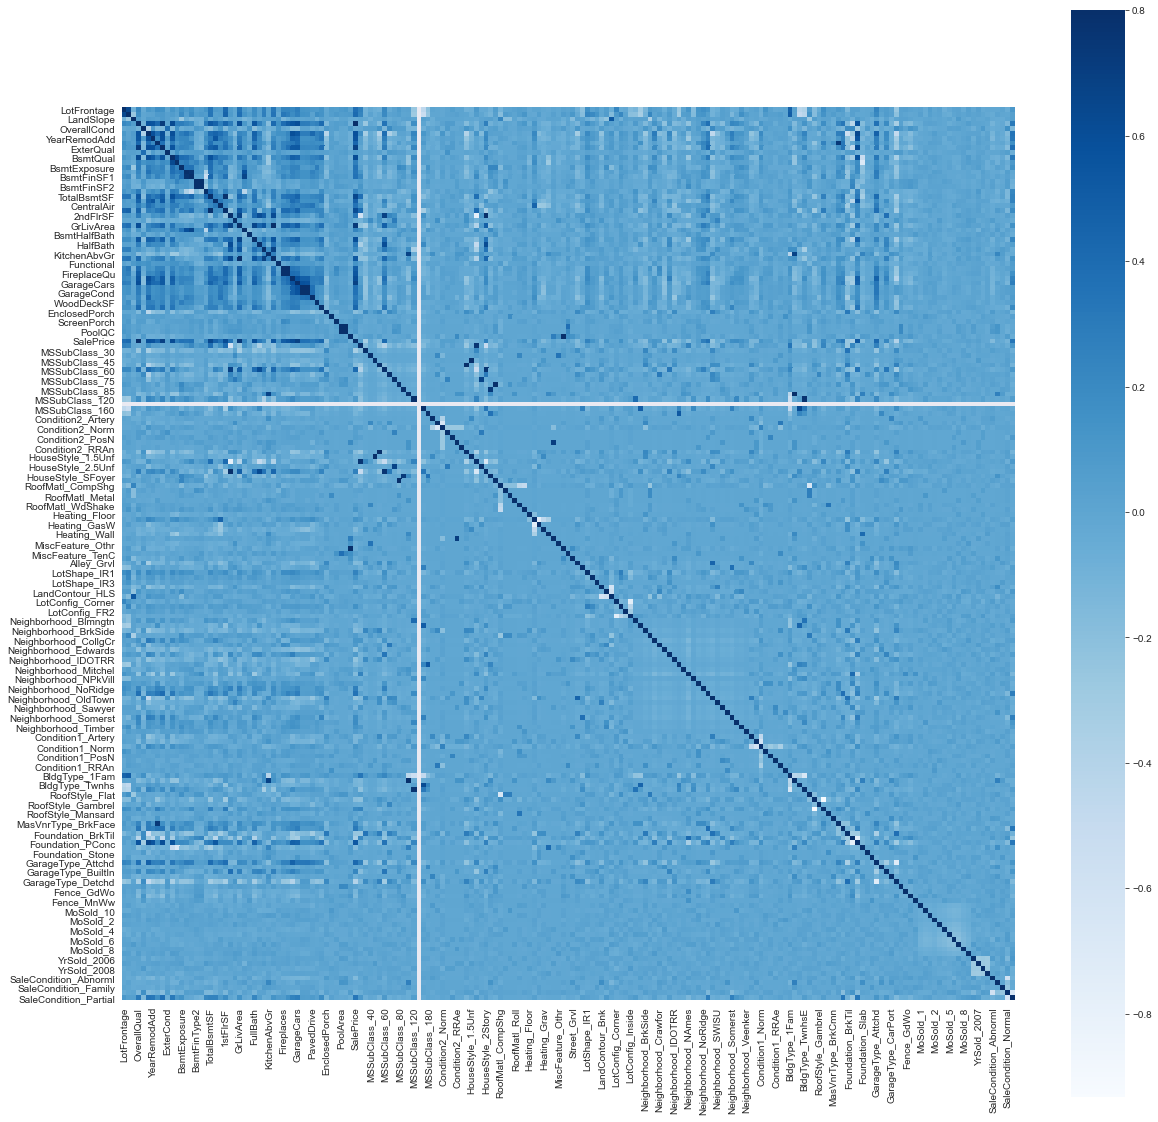

In [70]:
corr = train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, vmax=.8, square=True, cmap='Blues')
plt.show()

Now we've cleaned up all data and can move on to model fitting.

---

## 3. Model fitting <a name="model-fit"></a>

### Simple OLS model <a name="ols"></a>

We start with simple OLS model from <code>statsmodels</code> package:

In [71]:
Y_train = train.SalePrice
X_train = sm.add_constant(train.drop(columns=['SalePrice']))

In [72]:
X_train.shape, Y_train.shape

((1458, 185), (1458,))

In [73]:
model = sm.OLS(Y_train, X_train)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     111.3
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        04:45:52   Log-Likelihood:                 1329.1
No. Observations:                1458   AIC:                            -2292.
Df Residuals:                    1275   BIC:                            -1325.
Df Model:                         182                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.30

In [74]:
print('R^2 = {:f}'.format(fitted.rsquared))
print('F stat = {:f}'.format(fitted.f_pvalue))

R^2 = 0.940772
F stat = 0.000000


Our model is statistically significant explains 94% of the 'SalePrice' variation

In [75]:
sign_features = fitted.pvalues[fitted.pvalues < 0.05].index.values
print('Statistically significant features: \n{}'.format(sign_features))
print('({} out of {})'.format(len(sign_features), len(fitted.pvalues)))

Statistically significant features: 
['const' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'BsmtExposure' 'BsmtFinType1' 'BsmtUnfSF' 'TotalBsmtSF' 'HeatingQC'
 'CentralAir' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'Functional' 'GarageCars' 'WoodDeckSF'
 'ScreenPorch' 'MSSubClass_150' 'Condition2_RRAe' 'HouseStyle_1.5Unf'
 'RoofMatl_Membran' 'RoofMatl_WdShngl' 'Street_Grvl' 'LotConfig_CulDSac'
 'Condition1_RRAe' 'RoofStyle_Gambrel' 'Foundation_BrkTil'
 'Foundation_CBlock' 'Foundation_PConc' 'Foundation_Slab'
 'Foundation_Stone' 'GarageType_Attchd' 'GarageType_Basment'
 'GarageType_CarPort' 'SaleCondition_Abnorml' 'SaleCondition_Family']
(42 out of 185)


### Model diagnostics <a name="ols-diag"></a>

We can test whether the residuals are normally distributed with Kolmogorov-Smirnov test:

- H0: the distribution of residuals is not significantly different form the normal distribution
- H1: the distribution of residuals is significantly different form the normal distribution

In [77]:
p = kstest(fitted.resid, 'norm').pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


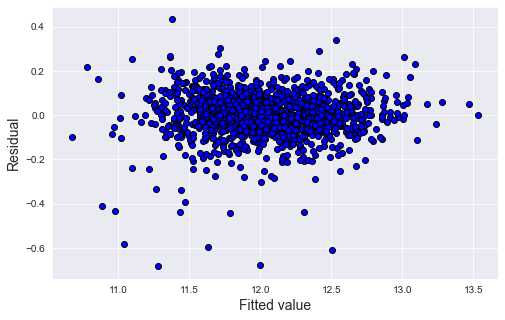

In [78]:
plt.figure(figsize=(8,5))
plt.scatter(x=fitted.fittedvalues, y=fitted.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

We can't see a heteroscedasticity from the plot above – there is no real relationship between residuals and the fitted values. This is also proved by Breusch-Pagan Lagrange Multiplier test:

In [79]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(fitted.resid, fitted.model.exog)

for n, t in zip(name, test):
    print('{}: {:.3f}'.format(n, t))

Lagrange multiplier statistic: 281.296
p-value: 0.000
f-value: 1.675
f p-value: 0.000


But we do have multicollinearity, which can be seen from heatmaps and proved by calculating VIFs:

In [80]:
vifs = np.array([vif(fitted.model.exog, i) for i in range(fitted.model.exog.shape[1])])
len(vifs[vifs > 10.0])

84

We should probably consider excluding features with high correlation.

### Multicollinearity elimination <a name="multi-elim"></a>

First, we find columns with the strongest correlation:

In [81]:
corr_mat = X_train.drop(columns=['const']).corr().abs()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

['BsmtFinSF2',
 'FireplaceQu',
 'GarageCond',
 'PoolQC',
 'HouseStyle_1.5Fin',
 'HouseStyle_1.5Unf',
 'HouseStyle_SLvl',
 'MiscFeature_Shed',
 'BldgType_Duplex',
 'RoofStyle_Hip']

Then we check VIF's again:

In [82]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = fitted.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
163,1.146,Fence_MnWw
161,1.195,Fence_GdWo
97,1.208,LotShape_IR3
44,1.235,ScreenPorch
78,1.249,RoofMatl_Membran
...,...,...
144,464.312,RoofStyle_Hip
142,502.711,RoofStyle_Gable
138,inf,BldgType_Duplex
58,inf,MSSubClass_90


In [85]:
vif_df[vif_df.VIF > 50].sort_values(by=['VIF'])

,VIF,Features
24,51.335,GrLivArea
125,51.376,Neighborhood_Somerst
149,54.712,Foundation_BrkTil
159,55.602,GarageType_Detchd
111,57.375,Neighborhood_Edwards
101,65.116,LotConfig_Corner
70,66.301,HouseStyle_1.5Fin
121,67.028,Neighborhood_OldTown
139,68.509,BldgType_Twnhs
182,70.171,SaleCondition_Normal


Looks like we probably should get rid of all 'MSSubClass_X' values except 'MSSubClass_40'

The same is about 'Neighborhood_X', 'RoofStyle_X', 'LotConfig_X' and 'Foundation_X' values

In [86]:
def remove_multicollinearity(data):
    print('Data shape before removing: {}'.format(data.shape))
    corr_mat = data.corr().abs()
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
    to_drop += ['MSSubClass_150', 'MSSubClass_90']
    to_drop += [col for col in upper.columns 
                if 'MSSubClass_' in col and col not in to_drop and col != 'MSSubClass_40']
    to_drop += [col for col in upper.columns 
                if 'Foundation_' in col and col not in to_drop and col != 'Foundation_Stone']
    to_drop += [col for col in upper.columns if 'Neighborhood_' in col and col not in to_drop]
    to_drop += [col for col in upper.columns if 'RoofStyle_' in col and col not in to_drop]
    to_drop += [col for col in upper.columns if 'LotConfig_' in col and col not in to_drop]
    to_drop += ['GarageType_BuiltIn', 'GarageType_Detchd', 
            'GarageType_Attchd', 'SaleCondition_Normal', 
            'SaleCondition_Partial', 'SaleCondition_Abnorml']
    to_drop += ['Condition1_Norm', 'TotalBsmtSF', 'Condition1_Feedr', 'Condition1_Artery']
    to_drop += ['Heating_GasA', 'Heating_GasW']
    cleaned = data.drop(columns=to_drop)
    print('Data shape after removing: {}'.format(cleaned.shape))
    return cleaned

In [87]:
scaler = StandardScaler()
scaled = train.drop(columns=['SalePrice'])
scaled[:] = scaler.fit_transform(scaled)
cleaned = remove_multicollinearity(scaled)
X_train_new = sm.add_constant(cleaned)
X_train_new

Data shape before removing: (1458, 184)
Data shape after removing: (1458, 112)


,const,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,SaleCondition_Alloca,SaleCondition_Family
0,1.000,-0.162,-0.129,0.226,0.659,-0.518,1.053,0.880,1.023,1.061,...,-0.458,-0.437,-0.302,-0.213,-0.524,-0.539,1.952,-0.549,-0.091,-0.118
1,1.000,0.531,0.119,0.226,-0.068,2.178,0.158,-0.428,-0.744,-0.689,...,-0.458,-0.437,-0.302,-0.213,-0.524,1.856,-0.512,-0.549,-0.091,-0.118
2,1.000,-0.017,0.428,0.226,0.659,-0.518,0.987,0.832,0.871,1.061,...,-0.458,-0.437,-0.302,4.706,-0.524,-0.539,1.952,-0.549,-0.091,-0.118
3,1.000,-0.410,0.109,0.226,0.659,-0.518,-1.863,-0.719,-0.744,-0.689,...,-0.458,-0.437,-0.302,-0.213,1.909,-0.539,-0.512,-0.549,-0.091,-0.118
4,1.000,0.704,0.889,0.226,1.385,-0.518,0.954,0.735,1.566,1.061,...,-0.458,-0.437,-0.302,-0.213,-0.524,-0.539,1.952,-0.549,-0.091,-0.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.000,-0.310,-0.256,0.226,-0.068,-0.518,0.920,0.735,-0.744,-0.689,...,-0.458,-0.437,3.309,-0.213,-0.524,1.856,-0.512,-0.549,-0.091,-0.118
1456,1.000,0.747,0.735,0.226,-0.068,0.381,0.225,0.153,0.651,-0.689,...,-0.458,-0.437,-0.302,-0.213,-0.524,-0.539,-0.512,-0.549,-0.091,-0.118
1457,1.000,-0.113,0.003,0.226,0.659,3.076,-1.001,1.026,-0.744,2.811,...,-0.458,-0.437,-0.302,-0.213,-0.524,-0.539,-0.512,-0.549,-0.091,-0.118
1458,1.000,-0.017,0.143,0.226,-0.795,0.381,-0.703,0.541,-0.744,-0.689,...,-0.458,-0.437,-0.302,-0.213,-0.524,-0.539,-0.512,-0.549,-0.091,-0.118


In [88]:
model_new = sm.OLS(Y_train, X_train_new)
fitted_new = model_new.fit()
print(fitted_new.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     142.8
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        04:57:29   Log-Likelihood:                 1132.2
No. Observations:                1458   AIC:                            -2038.
Df Residuals:                    1345   BIC:                            -1441.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.0240 

In [89]:
sign_features = fitted_new.pvalues[fitted_new.pvalues < 0.05].index.values
print('Statistically significant features: \n{}'.format(sign_features))
print('({} out of {})'.format(len(sign_features), len(fitted_new.pvalues)))

Statistically significant features: 
['const' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MasVnrArea' 'ExterQual' 'BsmtExposure' 'BsmtFinSF1' 'BsmtUnfSF'
 'HeatingQC' 'CentralAir' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd'
 'Functional' 'Fireplaces' 'GarageCars' 'PavedDrive' 'WoodDeckSF'
 'ScreenPorch' 'PoolArea' 'MiscFeature_TenC' 'Street_Grvl' 'Alley_Pave'
 'Condition1_RRAe' 'MasVnrType_BrkCmn' 'MasVnrType_BrkFace'
 'GarageType_CarPort' 'SaleCondition_Family']
(37 out of 113)


In [90]:
vifs_new = np.array([vif(fitted_new.model.exog, i) for i in range(fitted_new.model.exog.shape[1])])
len(vifs_new[vifs_new > 10.0])

3

Although we've lost some points in $R^2$, we've resolved multicollinearity and now we can trust model coefficients.

In [91]:
fitted_new.params[1:].sort_values()[-10:]

Functional    0.023
GarageCars    0.027
LotArea       0.045
BsmtFinSF1    0.047
OverallCond   0.049
2ndFlrSF      0.051
YearBuilt     0.066
1stFlrSF      0.068
GrLivArea     0.077
OverallQual   0.081
dtype: float64

In [92]:
fitted_new.params[1:].sort_values()[:10]

MasVnrType_BrkFace     -0.022
BedroomAbvGr           -0.018
KitchenAbvGr           -0.017
Condition1_RRAe        -0.011
Street_Grvl            -0.010
MasVnrType_BrkCmn      -0.009
MiscFeature_TenC       -0.008
GarageType_CarPort     -0.007
SaleCondition_Family   -0.007
Condition2_RRAe        -0.007
dtype: float64